In [2]:
import pandas as pd
score_paths = {
    'use': './scores/use_scores.csv',
    'stf': './scores/stf_scores.csv',
    'fasttext': './scores/fasttext_scores.csv',
    'glove': './scores/glove_scores.csv',
    'elmo': './scores/elmo_scores.csv',
}

model = 'use'
# Load the data
scores_df = pd.read_csv(score_paths[model])
goals_df = pd.read_csv('gpt_goals.csv')

# Display the first few rows of each DataFrame
print(scores_df.head())
print(goals_df.head())

                                    Authors   
0                   Kvasnica J.; Válková K.  \
1  Septriana F.E.; Soesilo T.E.B.; Sodri A.   
2                 Martak Y.F.; Nurhasana R.   
3                Tairas D.R.; Soenanto T.W.   
4                  Suresh R.; Murugaiyan V.   

                                   Author full names   
0  Kvasnica, Jakub (58021686400); Válková, Kateři...  \
1  Septriana, Fentinur Evida (57236202800); Soesi...   
2  Martak, Yusuf Faisal (57225954512); Nurhasana,...   
3  Tairas, David Ronald (57215000603); Soenanto, ...   
4  Suresh, R. (57205367211); Murugaiyan, V. (2664...   

                            Author(s) ID   
0               58021686400; 56719748600  \
1  57236202800; 57193915879; 56028045000   
2               57225954512; 57203681289   
3               57215000603; 57215004876   
4               57205367211; 26641414800   

                                               Title  Year   
0  HOLISTIC ASSESSMENT METHODOLOGY FOR POSITIVE E... 

C:\Users\235451\AppData\Local\Temp\ipykernel_16560\3243751683.py:12: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  scores_df = pd.read_csv(score_paths[model])


In [3]:
# Check for missing values
print(scores_df.isnull().sum())
print(goals_df.isnull().sum())

# Fill or drop missing values as needed
scores_df = scores_df.dropna(subset=['Title', 'Abstract'])  # Example: Drop rows where 'Title' or 'Abstract' is missing

# Convert similarity scores to numeric (if not already)
similarity_columns = [col for col in scores_df.columns if 'Goal_' in col]
scores_df[similarity_columns] = scores_df[similarity_columns].apply(pd.to_numeric, errors='coerce')


Authors                             15
Author full names                   15
Author(s) ID                        15
Title                                0
Year                                 0
Source title                         0
Volume                            8916
Issue                            19002
Art. No.                         17066
Page start                        9246
Page end                          9265
Page count                        9152
DOI                               2318
Link                                 0
Abstract                             0
Author Keywords                   5093
Index Keywords                    6381
Document Type                        0
Source                               0
EID                                  0
Abstract Length in Words             0
Abstract Length in Characters        0
Summary                              0
Summary Length in Words              0
Summary Length in Characters         0
Goal_1_Similarity        

In [5]:
average_similarity = (scores_df[similarity_columns].mean()).sort_values(ascending=False)
print(average_similarity)

Goal_11_Similarity    0.254118
Goal_7_Similarity     0.246916
Goal_12_Similarity    0.210734
Goal_1_Similarity     0.202809
Goal_2_Similarity     0.201972
Goal_14_Similarity    0.197583
Goal_9_Similarity     0.177033
Goal_6_Similarity     0.175433
Goal_3_Similarity     0.161622
Goal_8_Similarity     0.154605
Goal_5_Similarity     0.153826
Goal_4_Similarity     0.151379
Goal_15_Similarity    0.141052
Goal_13_Similarity    0.139649
Goal_16_Similarity    0.117795
Goal_17_Similarity    0.114708
Goal_10_Similarity    0.112339
dtype: float64


In [6]:
scores_df['Average_Similarity'] = scores_df[similarity_columns].mean(axis=1)
top_5_papers = scores_df.nlargest(5, 'Average_Similarity')
print(top_5_papers[['Title', 'Average_Similarity']])

                                                   Title  Average_Similarity
18581  Promoting global awareness of the SDGs in the ...            0.444147
21806  Automated Extraction of Active Offshore Oil/Ga...            0.427193
11076  Environmental Responsibilities of Local Govern...            0.424327
7328   Research on Digital Media Recommendation Algor...            0.420943
15347  Architecture for Wildlife: The Possible Soluti...            0.420900


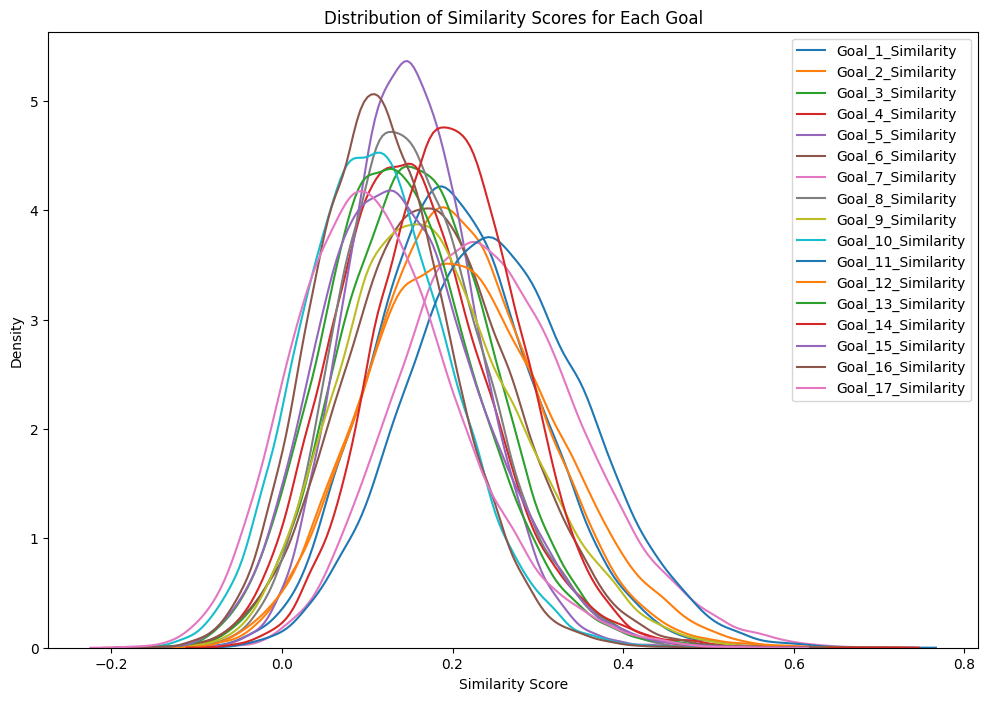

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for col in similarity_columns:
    sns.kdeplot(scores_df[col], label=col)

plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.title('Distribution of Similarity Scores for Each Goal')
plt.legend()
plt.show()

                    Goal_1_Similarity  Goal_2_Similarity  Goal_3_Similarity   
Goal_1_Similarity            1.000000           0.771679           0.750321  \
Goal_2_Similarity            0.771679           1.000000           0.714859   
Goal_3_Similarity            0.750321           0.714859           1.000000   
Goal_4_Similarity            0.629157           0.542575           0.601325   
Goal_5_Similarity            0.602021           0.559170           0.591905   
Goal_6_Similarity            0.552068           0.664640           0.620511   
Goal_7_Similarity            0.543874           0.682529           0.520213   
Goal_8_Similarity            0.644979           0.680785           0.599121   
Goal_9_Similarity            0.554446           0.597390           0.570814   
Goal_10_Similarity           0.642789           0.614649           0.647815   
Goal_11_Similarity           0.543001           0.634083           0.623987   
Goal_12_Similarity           0.433250           0.59

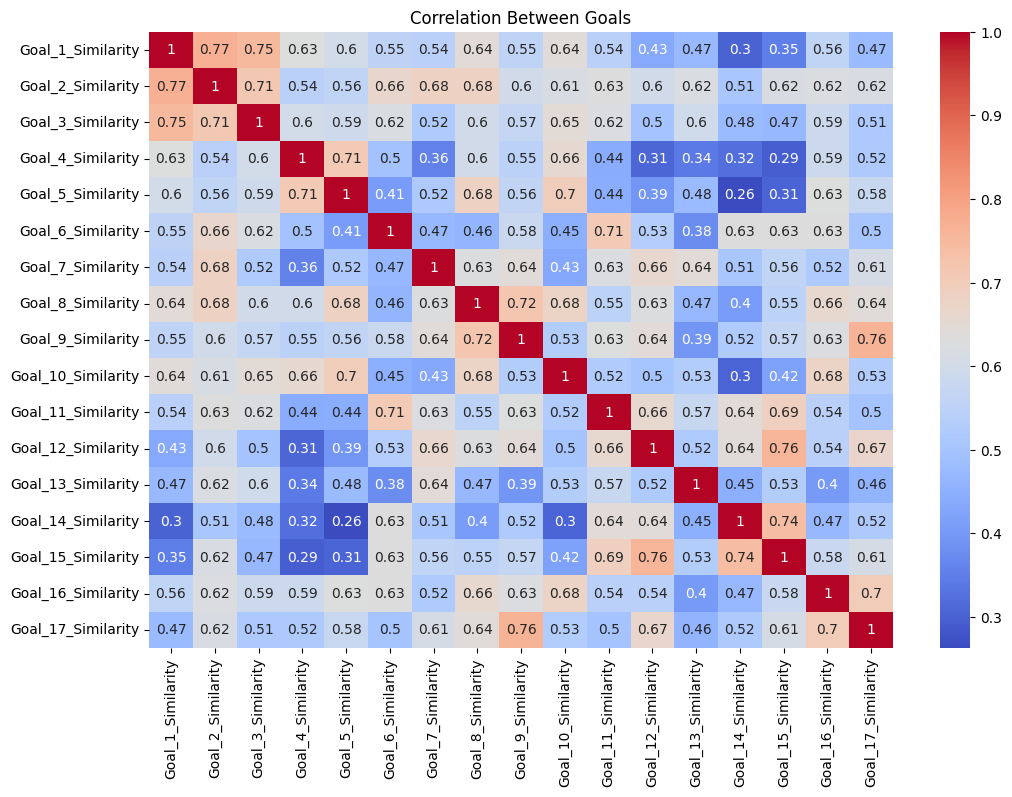

In [10]:
correlation_matrix = scores_df[similarity_columns].corr()
print(correlation_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Goals')
plt.show()


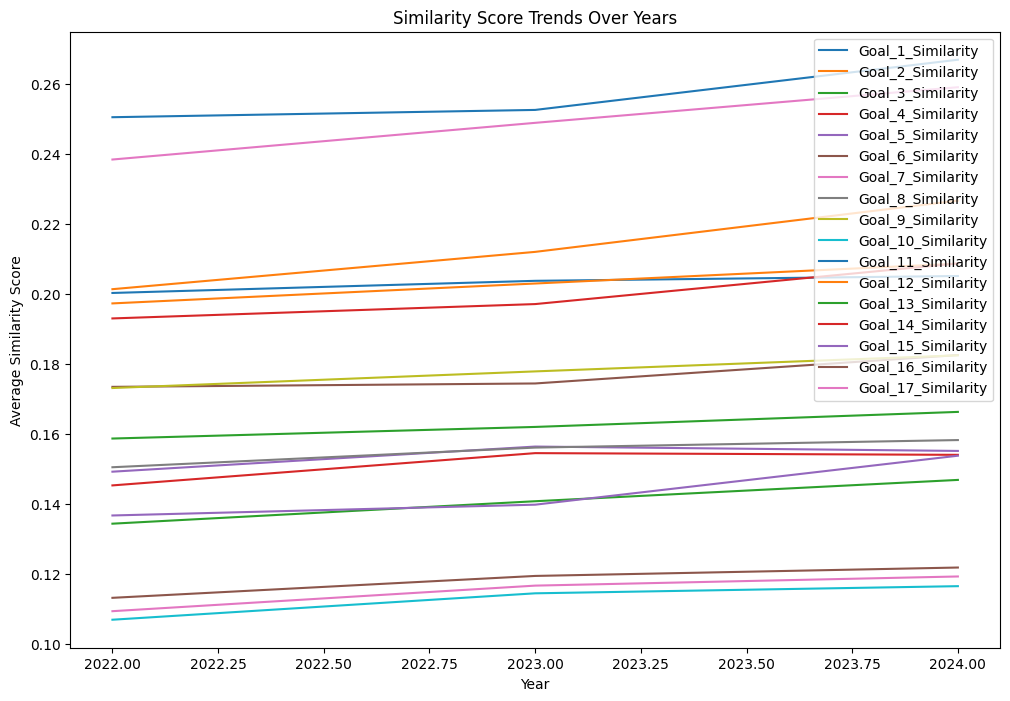

In [9]:
scores_df['Year'] = pd.to_numeric(scores_df['Year'], errors='coerce')
yearly_similarity = scores_df.groupby('Year')[similarity_columns].mean()

plt.figure(figsize=(12, 8))
for col in similarity_columns:
    plt.plot(yearly_similarity.index, yearly_similarity[col], label=col)

plt.xlabel('Year')
plt.ylabel('Average Similarity Score')
plt.title('Similarity Score Trends Over Years')
plt.legend()
plt.show()
